# 버트를 활용한 자연어 추론 모델

In [22]:
import os
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel

import numpy as np
import pandas as pd

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt

In [23]:
# 시각화

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [24]:
#random seed 고정

tf.random.set_seed(1234)
np.random.seed(1234)

# BASE PARAM

BATCH_SIZE = 32
NUM_EPOCHS = 3
MAX_LEN = 24 * 2 # Average total * 2

DATA_IN_PATH = './data_in/KOR'
DATA_OUT_PATH = "./data_out/KOR"

# KorNLI Dataset

Data from Kakaobrain:  https://github.com/kakaobrain/KorNLUDatasets

In [25]:
# Load Train dataset

TRAIN_SNLI_DF = os.path.join(DATA_IN_PATH, 'KorNLI', 'snli_1.0_train.kor.tsv')
TRAIN_XNLI_DF = os.path.join(DATA_IN_PATH, 'KorNLI', 'multinli.train.ko.tsv')
DEV_XNLI_DF = os.path.join(DATA_IN_PATH, 'KorNLI', 'xnli.dev.ko.tsv')

train_data_snli = pd.read_csv(TRAIN_SNLI_DF, header=0, delimiter = '\t', quoting = 3)
train_data_xnli = pd.read_csv(TRAIN_XNLI_DF, header=0, delimiter = '\t', quoting = 3)
# 검증데이터
dev_data_xnli = pd.read_csv(DEV_XNLI_DF, header=0, delimiter = '\t', quoting = 3)

train_data_snli_xnli = train_data_snli.append(train_data_xnli)
# 중복값 제거
train_data_snli_xnli = train_data_snli_xnli.dropna()
# 인덱스 초기화
train_data_snli_xnli = train_data_snli_xnli.reset_index(drop=True)

dev_data_xnli = dev_data_xnli.dropna()

print("Total # dataset: train - {}, dev - {}".format(len(train_data_snli_xnli), len(dev_data_xnli)))

/var/folders/f7/gl6wpvqx5z596rbpjsq5n3tc0000gn/T/ipykernel_13912/1608151549.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data_snli_xnli = train_data_snli.append(train_data_xnli)


Total # dataset: train - 942808, dev - 2490


In [26]:
train_data_snli_xnli

,sentence1,sentence2,gold_label
0,말을 탄 사람이 고장난 비행기 위로 뛰어오른다.,한 사람이 경쟁을 위해 말을 훈련시키고 있다.,neutral
1,말을 탄 사람이 고장난 비행기 위로 뛰어오른다.,한 사람이 식당에서 오믈렛을 주문하고 있다.,contradiction
2,말을 탄 사람이 고장난 비행기 위로 뛰어오른다.,사람은 야외에서 말을 타고 있다.,entailment
3,카메라에 웃고 손을 흔드는 아이들,그들은 부모님을 보고 웃고 있다,neutral
4,카메라에 웃고 손을 흔드는 아이들,아이들이 있다,entailment
...,...,...,...
942803,"분명히, 캘리포니아는 더 잘 할 수 있고, 더 잘해야 한다.",캘리포니아는 더 잘할 수 없다.,contradiction
942804,"한때 유럽에서 가장 아름다운 거리로 여겨졌는데, 이는 원래의 많은 건물들이 교체되었...",그래서 원래의 많은 건물들이 편의점으로 대체되었다.,neutral
942805,하우스보트는 영국 라지의 전성기의 아름답게 보존된 전통이다.,하우스보트의 전통은 영국 라지가 여전히 강해지는 동안 시작되었다.,entailment
942806,사망 기사는 그의 평론가의 신디케이트 TV 쇼에서 동료 검토 자 Roger Eber...,부고문은 아름다웠고 연예계에서의 그의 업적에 대해 현물로 쓰여졌다.,neutral


# 훈련시간의 효횰을 높이기 위해 훈련 데이터 1/10 축소

In [27]:
drop_length = len(train_data_snli_xnli) // 10

train_data_snli_xnli = train_data_snli_xnli.iloc[:drop_length]

In [28]:
# Bert Tokenizer

# 참조: https://huggingface.co/transformers/main_classes/tokenizer.html?highlight=encode_plus#transformers.PreTrainedTokenizer.encode_plus

# 사용할 토크나이저 결정
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased", cache_dir='bert_ckpt', do_lower_case=False,
                                          clean_up_tokenization_spaces = True)

def bert_tokenizer_v2(sent1, sent2, MAX_LEN):
    
    # For Two setenece input
    encoded_dict = tokenizer.encode_plus(
        text=sent1,
        text_pair=sent2,
        add_special_tokens=True,  # '[CLS]' 및 '[SEP]' 토큰 추가
        max_length=MAX_LEN,       # 문장 패딩 및 자르기 설정
        padding='max_length',     # 'pad_to_max_length' 대신 사용
        truncation=True,          # 잘라내기 설정
        return_attention_mask=True, # 어텐션 마스크 반환
        return_overflowing_tokens=False # 경고 메시지를 없애기 위한 옵션 (기본값도 false이지만 경고 문구를 제거하기 위해 추가적으로 명시)
    )
    
    
    input_id = encoded_dict['input_ids']
    attention_mask = encoded_dict['attention_mask'] # And its attention mask (simply differentiates padding from non-padding).
    token_type_id = encoded_dict['token_type_ids'] # differentiate two sentences
    
    return input_id, attention_mask, token_type_id


## 트러블슈팅
- jupyter notebook 출력 문제로 인한 경고 발생  
(jupyter notebook config.py 문구 수정)
> c.ServerApp.iopub_data_rate_limit = 10000000  # 기본값보다 크게 설정  
> c.ServerApp.rate_limit_window = 10.0  # 시간 창을 넓혀 출력 속도 제한을 늘림
- 잘려진 토큰에 대해서 반환이 되지 않는 다는 경고 발생  
(transformer의 자체 로깅레벨 변경)
> 로깅 레벨을 Error로 설정  
> logging.set_verbosity_error()

In [29]:
print(len(train_data_snli_xnli['sentence1']))
print(len(train_data_snli_xnli['sentence2']))

94280
94280


In [30]:
print(train_data_snli_xnli.sentence1[0], train_data_snli_xnli.sentence2[0])

말을 탄 사람이 고장난 비행기 위로 뛰어오른다. 한 사람이 경쟁을 위해 말을 훈련시키고 있다.


In [31]:
# pip show transformers

In [11]:
# pip install --upgrade transformers

In [32]:
from transformers import logging

# 로깅 레벨을 Error로 설정
logging.set_verbosity_error()

# TRAIN SET Preprocessing

In [33]:
input_ids = []
attention_masks = []
token_type_ids = []

for sent1, sent2 in zip(train_data_snli_xnli['sentence1'], train_data_snli_xnli['sentence2']):
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer_v2(sent1, sent2, MAX_LEN)  # 잘려진 토큰 반환하지 않도록 설정)

        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
    except Exception as e:
        print(e)
        print(sent1, sent2)
        break

# bert_tkenizer 의 형태가 리스트 형태로 반환되기 때문에 직접 변경
train_snli_xnli_input_ids = np.array(input_ids, dtype=int)
train_snli_xnli_attention_masks = np.array(attention_masks, dtype=int)
train_snli_xnli_type_ids = np.array(token_type_ids, dtype=int)
train_snli_xnli_inputs = (train_snli_xnli_input_ids, train_snli_xnli_attention_masks, train_snli_xnli_type_ids)

In [34]:
# 로깅 레벨을 기본값인 WARNING으로 원복
logging.set_verbosity_warning()

In [35]:
input_id = train_snli_xnli_input_ids[2]
attention_mask = train_snli_xnli_attention_masks[2]
token_type_id = train_snli_xnli_type_ids[2]

print(input_id)
print(attention_mask)
print(token_type_id)
print(tokenizer.decode(input_id))

[  101  9251 10622  9847 97802  8888 13890 33305  9379 25549 12310  9619
 11261  9150 12965 28188 66346   119   102  9405 61250 10892  9538 78705
 11489  9251 10622  9845 11664 11506   119   102     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0]
[CLS] 말을 탄 사람이 고장난 비행기 위로 뛰어오른다. [SEP] 사람은 야외에서 말을 타고 있다. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


# DEV SET Preprocessing

In [36]:
# transformer 로깅 레벨을 Error로 설정
logging.set_verbosity_error()

# 토크나이저를 제외하고는 5장에서 처리한 방식과 유사하게 접근
input_ids = []
attention_masks = []
token_type_ids = []

for sent1, sent2 in zip(dev_data_xnli['sentence1'], dev_data_xnli['sentence2']):
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer_v2(sent1, sent2, MAX_LEN)  # 잘려진 토큰 반환하지 않도록 설정)

        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
    except Exception as e:
        print(e)
        print(sent1, sent2)
        break

# transformer 로깅 레벨을 warning 도 출력하도록 변경
logging.set_verbosity_warning()

# bert_tkenizer 의 형태가 리스트 형태로 반환되기 때문에 직접 변경
dev_xnli_input_ids = np.array(input_ids, dtype=int)
dev_xnli_attention_masks = np.array(attention_masks, dtype=int)
dev_xnli_type_ids = np.array(token_type_ids, dtype=int)
dev_xnli_inputs = (dev_xnli_input_ids, dev_xnli_attention_masks, dev_xnli_type_ids)

In [37]:
# Label을 Netural, Contradiction, Entailment 에서 숫자 형으로 변경한다
label_dict = {"entailment": 0, "contradiction": 1, "neutral": 2}
def convert_int(label):
    num_label = label_dict[label]
    return num_label

train_data_snli_xnli['gold_label_int'] = train_data_snli_xnli["gold_label"].apply(convert_int)
train_data_labels = np.array(train_data_snli_xnli['gold_label_int'], dtype=int)

dev_data_xnli["gold_label_int"] = dev_data_xnli["gold_label"].apply(convert_int)
dev_data_labels = np.array(dev_data_xnli['gold_label_int'], dtype=int)

print(f"# train labels: {len(train_data_labels)}, # dev labels: {len(dev_data_labels)}" )

# train labels: 94280, # dev labels: 2490


/var/folders/f7/gl6wpvqx5z596rbpjsq5n3tc0000gn/T/ipykernel_13912/308362214.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_snli_xnli['gold_label_int'] = train_data_snli_xnli["gold_label"].apply(convert_int)


In [38]:
# 사전 학습된 모델을 가져와서 가중치를 로드하고, 클래스 수에 맞는 분류기 정의
class TFBertClassifier(tf.keras.Model):
    def __init__(self, model_name, dir_path, num_class):
        super(TFBertClassifier, self).__init__()
        # Transformers 라이브러리에서 제공하는 메서드로, 사전 학습된(pre-trained) BERT 모델을 불러오는 역할
        # from_pretrained 메서드는 사전 학습된 가중치(weights)와 설정(config)을 가져와서 모델을 생성
        # 이 과정에서 모델이 처음부터 학습되지 않고, 사전 학습된 BERT의 지식이 그대로 유지
        self.bert = TFBertModel.from_pretrained(model_name, cache_dir = dir_path)
        self.dropout = tf.keras.layers.Dropout(self.bert.config.hidden_dropout_prob)
        # 중치 초기화 방식을 정의합니다 (initializer_range)
        self.classifier = tf.keras.layers.Dense(num_class,
                                                kernel_initializer=tf.keras.initializers.TruncatedNormal(self.bert.config.initializer_range), 
                                                name = "classifier")

    def call(self, inputs, attention_mask=None, token_type_ids=None, training= False):
        # output 값: # sequence_output, pooled_output, (hidden_states), (attentions)
        outputs = self.bert(inputs, attention_mask = attention_mask, token_type_ids = token_type_ids)
        # BERT의 최종 출력 중, 첫 번째 [CLS] 토큰에 해당하는 임베딩 값을 의미합니다.
        # 이는 주로 문장 수준의 분류 작업에 사용됩니다
        pooled_output = outputs[1]
        pooled_output = self.dropout(pooled_output, training = training)
        # 드롭아웃된 출력(pooled_output)을 Dense 레이어(분류기)에 통과시켜, 
        # 최종적인 로짓(logits)을 얻습니다. 이 값은 클래스별로 예측된 점수.
        logits = self.classifier(pooled_output)

        return logits

cls_model = TFBertClassifier(model_name = 'bert-base-multilingual-cased',
                             dir_path = 'bert_ckpt',
                             num_class = 3
                            )

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [39]:
# 학습 준비하기
optimizer = tf.keras.optimizers.Adam(3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
cls_model.compile(optimizer = optimizer, loss = loss, metrics = [metrics])

# !!!!노트북으로 훈련 시 너무 훈련시간의 소요가 높아 효율성을 높이기 위해 훈련 데이터를 약 1/10으로 변경  
# (위쪽으로 다시 올라가서 훈련 데이터 업로드(전처리 다시 진행)

In [40]:
# 데이터 타입 및 모양 확인
print(type(train_snli_xnli_input_ids), train_snli_xnli_input_ids.dtype)
print(type(train_snli_xnli_attention_masks), train_snli_xnli_attention_masks.dtype)
print(type(train_snli_xnli_type_ids), train_snli_xnli_type_ids.dtype)
print(type(train_data_labels), train_data_labels.dtype)



print(type(dev_xnli_input_ids), dev_xnli_input_ids.dtype)
print(type(dev_xnli_attention_masks), dev_xnli_attention_masks.dtype)
print(type(dev_xnli_type_ids), dev_xnli_type_ids.dtype)
print(type(dev_data_labels), dev_data_labels.dtype)

<class 'numpy.ndarray'> int64
<class 'numpy.ndarray'> int64
<class 'numpy.ndarray'> int64
<class 'numpy.ndarray'> int64
<class 'numpy.ndarray'> int64
<class 'numpy.ndarray'> int64
<class 'numpy.ndarray'> int64
<class 'numpy.ndarray'> int64


In [41]:
# 학습 진행하기 
model_name = 'tf2_KorNLI'

# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001,patience=2)
checkpoint_path = os.path.join(DATA_OUT_PATH, model_name, '.weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

# 학습과 eval시작
history = cls_model.fit(train_snli_xnli_inputs, train_data_labels, epochs=NUM_EPOCHS,
                        validation_data=(dev_xnli_inputs, dev_data_labels),
                        batch_size = BATCH_SIZE, callbacks=[earlystop_callback, cp_callback])

# step_for_epoch
print(history.history)

./data_out/KOR/tf2_KorNLI -- Folder already exists 

Epoch 1/3
2947/2947 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3576 - loss: 1.0975
Epoch 1: val_accuracy improved from -inf to 0.33574, saving model to ./data_out/KOR/tf2_KorNLI/.weights.h5
2947/2947 ━━━━━━━━━━━━━━━━━━━━ 3186s 1s/step - accuracy: 0.3576 - loss: 1.0975 - val_accuracy: 0.3357 - val_loss: 1.1160
Epoch 2/3
2947/2947 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4011 - loss: 1.0853
Epoch 2: val_accuracy improved from 0.33574 to 0.34578, saving model to ./data_out/KOR/tf2_KorNLI/.weights.h5
2947/2947 ━━━━━━━━━━━━━━━━━━━━ 3348s 1s/step - accuracy: 0.4011 - loss: 1.0853 - val_accuracy: 0.3458 - val_loss: 1.1110
Epoch 3/3
2947/2947 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4218 - loss: 1.0768
Epoch 3: val_accuracy improved from 0.34578 to 0.35181, saving model to ./data_out/KOR/tf2_KorNLI/.weights.h5
2947/2947 ━━━━━━━━━━━━━━━━━━━━ 3184s 1s/step - accuracy: 0.4218 - loss: 1.0768 - val_accuracy: 0.3518 - val_loss: 1.1068

In [42]:
# 데이터 타입 확인
print(type(train_snli_xnli_inputs[0]))  # input_ids
print(type(train_snli_xnli_inputs[1]))  # attention_masks
print(type(train_snli_xnli_inputs[2]))  # token_type_ids

print(type(train_data_labels))  # 데이터 타입 확인
print(train_data_labels.dtype)  # 레이블 데이터의 dtype 확인



<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
int64


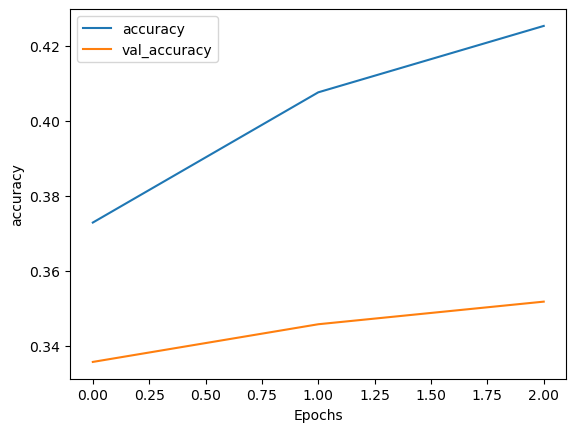

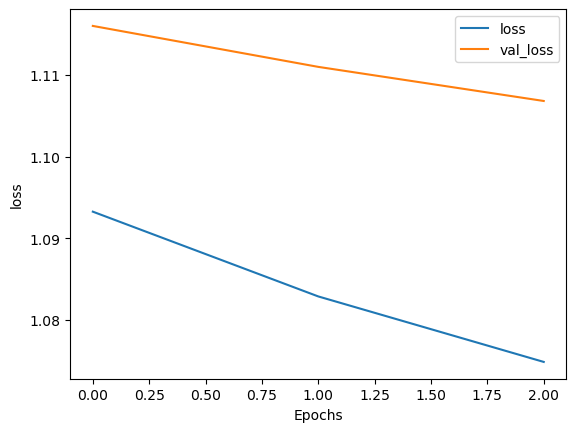

In [43]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

# KorNLI Test dataset

In [45]:
# Load Test dataset

TEST_XNLI_DF = os.path.join(DATA_IN_PATH, 'KorNLI', 'xnli.test.ko.tsv')

test_data_xnli = pd.read_csv(TEST_XNLI_DF, header=0, delimiter = '\t', quoting = 3)

# 중복값 제거
test_data_xnli = test_data_xnli.dropna()
# 인덱스 초기화
test_data_xnli = test_data_xnli.reset_index(drop=True)
test_data_xnli.head()

,sentence1,sentence2,gold_label
0,"글쎄, 나는 그것에 관해 생각조차 하지 않았지만, 나는 너무 좌절했고, 결국 그에게...",나는 그와 다시 이야기하지 않았다.,contradiction
1,"글쎄, 나는 그것에 관해 생각조차 하지 않았지만, 나는 너무 좌절했고, 결국 그에게...",나는 다시 그와 이야기를 하기 시작했다는 것에 너무 화가 났다.,entailment
2,"글쎄, 나는 그것에 관해 생각조차 하지 않았지만, 나는 너무 좌절했고, 결국 그에게...",우리는 좋은 대화를 나눴다.,neutral
3,"그리고 저는 그것이 특권이라고 생각했습니다, 그리고 여전히, 여전히, 당시 저는 A...",그날 현장에 나만 있었던 게 아니라는 걸 몰랐던 것이다.,neutral
4,"그리고 저는 그것이 특권이라고 생각했습니다, 그리고 여전히, 여전히, 당시 저는 A...",나는 AFFC 공군 경력 분야에서 그 번호를 가진 유일한 사람이라는 인상을 가지고 ...,entailment


In [47]:
# transformer 로깅 레벨을 Error로 설정
logging.set_verbosity_error()

# 토크나이저를 제외하고는 5장에서 처리한 방식과 유사하게 접근
input_ids = []
attention_masks = []
token_type_ids = []

for sent1, sent2 in zip(test_data_xnli['sentence1'], test_data_xnli['sentence2']):
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer_v2(sent1, sent2, MAX_LEN)  # 잘려진 토큰 반환하지 않도록 설정)

        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
    except Exception as e:
        print(e)
        print(sent1, sent2)
        break

# transformer 로깅 레벨을 warning 도 출력하도록 변경
logging.set_verbosity_warning()

# bert_tkenizer 의 형태가 리스트 형태로 반환되기 때문에 직접 변경
test_xnli_input_ids = np.array(input_ids, dtype=int)
test_xnli_attention_masks = np.array(attention_masks, dtype=int)
test_xnli_type_ids = np.array(token_type_ids, dtype=int)
test_xnli_inputs = (test_xnli_input_ids, test_xnli_attention_masks, test_xnli_type_ids)

In [48]:
test_data_xnli["gold_label_int"] = test_data_xnli["gold_label"].apply(convert_int)
test_data_xnli_labels = np.array(test_data_xnli['gold_label_int'], dtype=int)

print(f"# sents: {len(test_xnli_input_ids)}, # labels: {len(test_data_xnli_labels)}" )

# sents: 5010, # labels: 5010


In [49]:
result = cls_model.evaluate(test_xnli_inputs, test_data_xnli_labels, batch_size = 512)
print("test loss, test acc: ", result)

10/10 ━━━━━━━━━━━━━━━━━━━━ 135s 14s/step - accuracy: 0.3436 - loss: 1.1090
test loss, test acc:  [1.1065188646316528, 0.35169661045074463]
